In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
#!pip install -q -U tensorboard

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 64

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset
    
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    dataset = dataset.cache() if cache else dataset

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2

# I'll focus now on synthesizing T2 from T1

validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])

In [0]:
# PROCESSING IMAGES IN THE BATCH

def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    for i in range(BATCH_SIZE):
        batch[i] = np.frombuffer(batch[i], dtype=np.float32)
        if i == 0:
            conc = batch[0]
        else:
            conc = np.concatenate((conc, batch[i]), axis=0)
    # after this the shape is (bs*32400, )
    final = np.reshape(conc, (BATCH_SIZE, 180, 180))
    # after this the shape is (bs, 180, 180)

    # padding the images in order to be compatible with the U-net input:
    npad = ((0, 0), (38, 38), (38, 38))
    final = np.pad(final, pad_width=npad, mode='constant', constant_values=0)
    final = np.expand_dims(final, axis=3)
    return final

# finale shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

Batch with a size of 64 and dimension of (256,256) per image


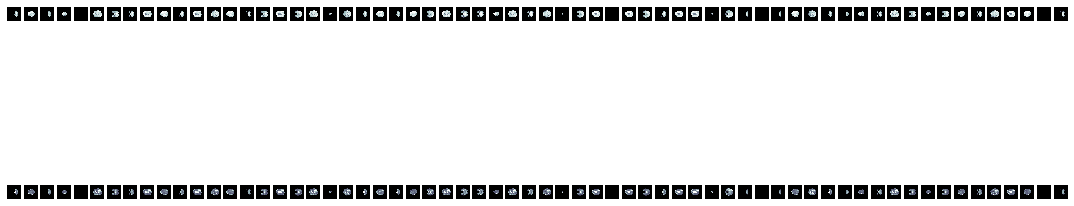

In [9]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
plt.figure(1 , figsize = (19, 6))
for raw_record in validation.take(1):
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    n = 0 
    for mod in modalities:
        image = raw_record[mod].numpy()
        preprocessed_batch = process_batch(image)    
        for i in range(BATCH_SIZE):
            n += 1
            plt.subplot(2 , BATCH_SIZE , n)
            img = preprocessed_batch[i]
            plt.imshow(np.squeeze(img), cmap='bone')
            plt.axis('off')

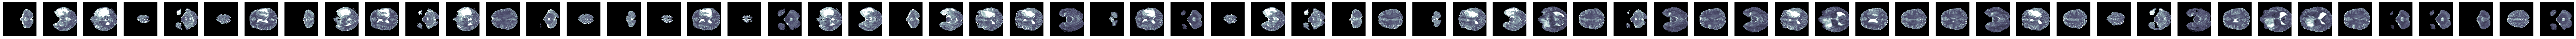

In [39]:
plt.figure(1 , figsize = (120 , 120))
n = 0     
for i in range(BATCH_SIZE):
    image = raw_record[modalities[1]].numpy()
    
    output = np.frombuffer(image[i], dtype=np.float32)
    test = np.reshape(output, (180, 180))
    n += 1
    plt.subplot(1 , BATCH_SIZE , n)
    plt.imshow(test, cmap='bone')
    plt.axis('off')

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  print(x.shape)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(64, 256, 256, 1)


In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN

def take_images_from_raw(raw_record):
    inp = np.empty(4)
    ground_truth = np.empty(4)
    for raw_record in validation.take(1):
        n = 0 
        for idx, mod in enumerate(modalities):
            image = raw_record[mod].numpy()
            if idx == 0:
                inp = process_batch(image) 
            else:
                ground_truth = process_batch(image)

    return inp, ground_truth

In [0]:
def generate_images(model, test_input, tar, train):
    
    # FROM STACKOVERFLOW:
    # Some neural network layers behave differently during training and inference, for example Dropout and BatchNorm
    # During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
    # During inference (training=false) it does nothing (since you usually don't want the randomness of dropping out units here).
    # The training argument lets the layer know which of the two "paths" it should take. 
    # If you set this incorrectly, your network might not behave as expected.

    prediction = model(test_input, training=train)

    print(prediction.shape)
    print("1st sample from the batch. Dimension of (256,256) per image".format(BATCH_SIZE))
    
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(1 , figsize = (12 , 12))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(np.squeeze(display_list[i][0]), cmap='bone') # [0] = I'm showing only the 1st sample
        plt.axis('off')
    plt.show()


In [0]:
def generate_complete_batch(model, test_input, tar, train):
    prediction = model(test_input, training=train)

    print(prediction.shape)
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.figure(i+1 , figsize = (120 , 360))
        n = 0
        for j in range(BATCH_SIZE):
            n += 1
            plt.subplot(1, BATCH_SIZE, n).title.set_text(title[i])
            plt.imshow(np.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')



**Prediction of T2, given random input T1 and ground truth T2**


(64, 256, 256, 1)
Batch with a size of 64 and dimension of (256,256) per image


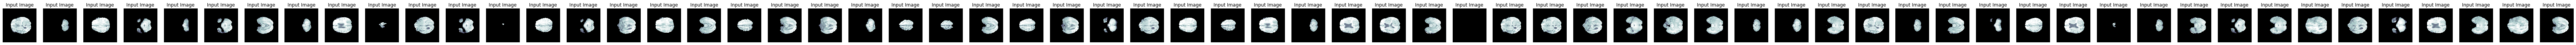

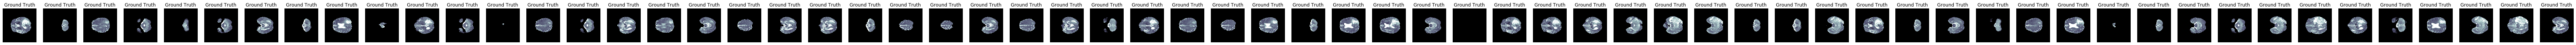

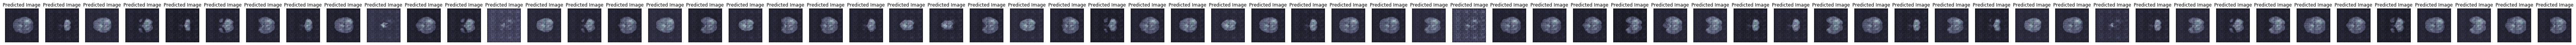

In [41]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
example_input = np.empty(4)
example_target = np.empty(4)
for raw_record in testing.take(1):
    example_input, example_target = take_images_from_raw(raw_record)

# Shape of both input and target is: (10, 256, 256, 1)

# GENERATE A NEW MODALITY:

# the functions below do exactly the same thing, but the first prints only the first sample from the batch, 
# while w/the second ALL the images of the batch are printed out.

#generate_images(generator, example_input, example_target, False)
generate_complete_batch(generator, example_input, example_target, False)

In [0]:
LAMBDA = 100

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  print(inp.shape, tar.shape)
  print(last.shape)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [23]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

(64, 256, 256, 1) (64, 256, 256, 1)
(64, 30, 30, 1)


In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
def take_images_from_raw_enum(raw_record, modalities):
    # so each raw_record is a tuple. each tuple contains all the features.
    # each features is stored inside the tuple as a tensor. how to access to it?
    
    # to retrieve an image:
    inp_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[0]].numpy()[0], dtype=np.float32), (180, 180))
    ground_truth_from_enum = np.reshape(np.frombuffer(raw_record[1][modalities[1]].numpy()[0], dtype=np.float32), (180, 180))
    inp_from_enum = np.expand_dims(inp_from_enum, axis=2)
    ground_truth_from_enum = np.expand_dims(ground_truth_from_enum, axis=2)
    # the shape now is (180,180,1)  
    # I need to resize the input images in order to feed them to the U-net. 
    # With 128 I would decrease the resolution, so let's increase it to 256
    inp_from_enum_resized, ground_truth_from_enum_resized = resize(inp_from_enum, ground_truth_from_enum, 256, 256)
    # the shape now is (256,256,1)

    # NOW IS READY FOR THE generate_images METHOD
    # to retrieve the patient_code, do this:  (not useful right now)
    #test2 = raw_record[1]['MR_T1_patient'].numpy()[0]
    #patient = test2.decode("utf-8")
    inp_from_enum_resized = inp_from_enum_resized[tf.newaxis,...]
    ground_truth_from_enum_resized = ground_truth_from_enum_resized[tf.newaxis,...]

    return inp_from_enum_resized, ground_truth_from_enum_resized
    

In [0]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

**TRAINING PHASE**

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # this has nothing to do with the training. 
    # It's just to show qualitatively the progress of the GAN in generating a new image.
    for raw_record in test_ds.take(1):
        example_input, example_target = take_images_from_raw(raw_record)
        generate_images(generator, example_input, example_target, True)
    print("Epoch: ", epoch)

    # Train
    n = 0
    for raw_record_enum in train_ds.take(16):
        n += 1
        input_image, target = take_images_from_raw(raw_record_enum)
        print('.', end='')
        if (n+1) % 100 == 0:
            print(n)
            print()
        # THIS IS THE ACTUAL TRAINING STEP
        train_step(input_image, target, epoch)
        
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


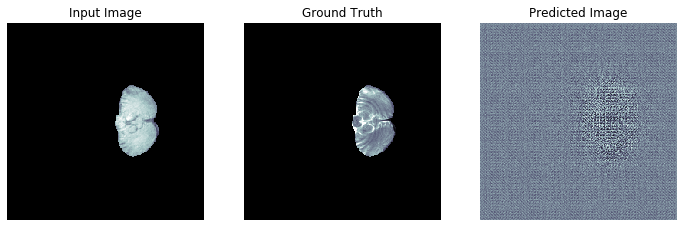

Epoch:  0
................
Time taken for epoch 1 is 31.807101011276245 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


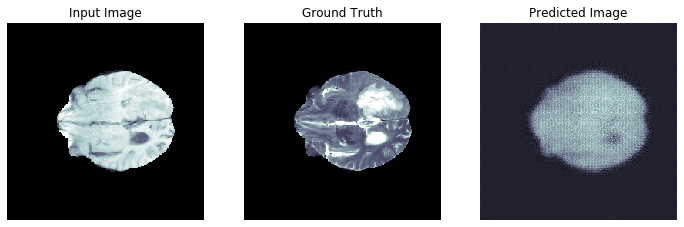

Epoch:  1
................
Time taken for epoch 2 is 26.49526286125183 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


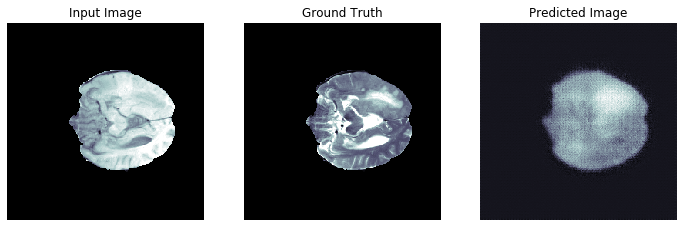

Epoch:  2
................
Time taken for epoch 3 is 26.56588315963745 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


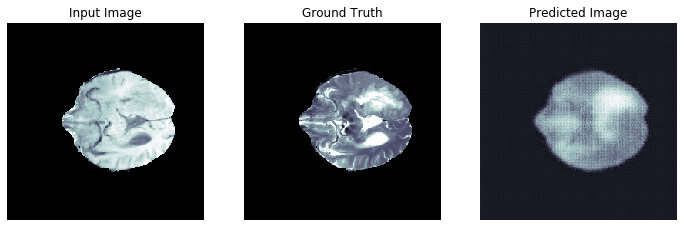

Epoch:  3
................
Time taken for epoch 4 is 26.63667583465576 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


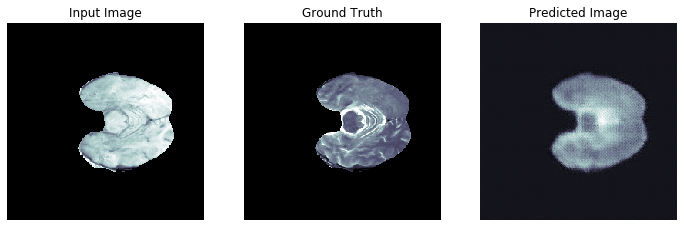

Epoch:  4
................
Time taken for epoch 5 is 26.699792861938477 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


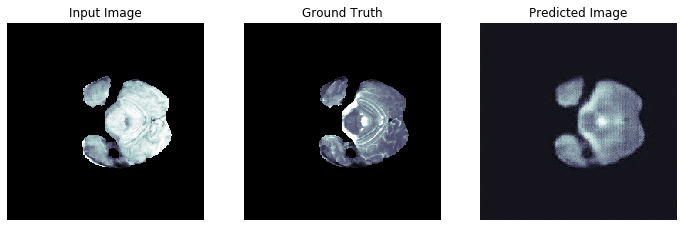

Epoch:  5
................
Time taken for epoch 6 is 26.481695890426636 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


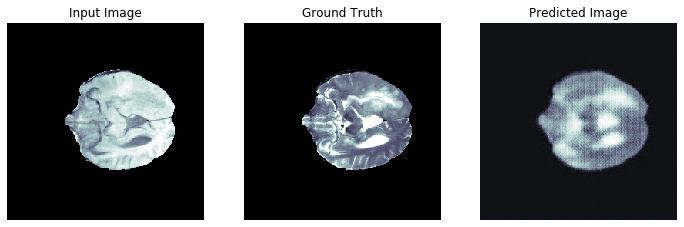

Epoch:  6
................
Time taken for epoch 7 is 26.84701442718506 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


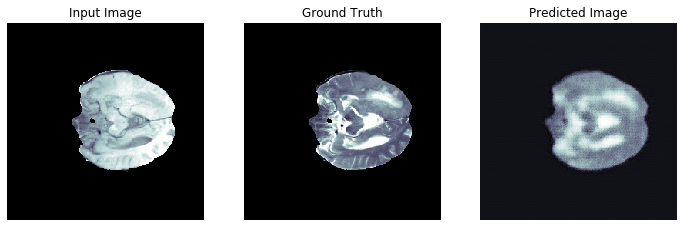

Epoch:  7
................
Time taken for epoch 8 is 26.43710970878601 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


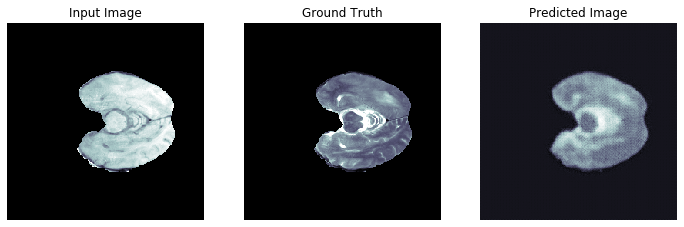

Epoch:  8
................
Time taken for epoch 9 is 26.798965215682983 sec

(64, 256, 256, 1)
1st sample from the batch. Dimension of (256,256) per image


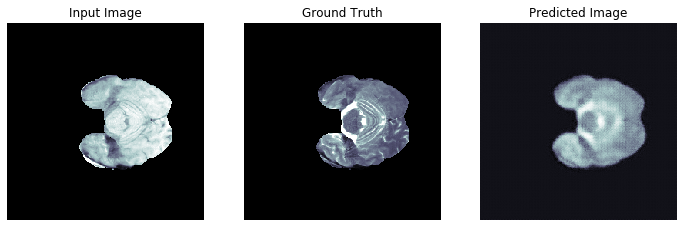

Epoch:  9
................
Time taken for epoch 10 is 26.421472787857056 sec



In [31]:
EPOCHS = 10
fit(training, EPOCHS, testing)

In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32 (28 in the most recent)seconds
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.